# Getting parameters from runs with py3DCORE_h4c

In [9]:
%load_ext autoreload

%autoreload 2

import heliosat as heliosat
import logging as logging
import datetime as datetime
import numpy as np
import os as os
import pickle as pickle
import py3dcore_h4c as py3dcore_h4c
import matplotlib.pyplot as plt
import shutil as shutil
import pandas as pds
import event as evt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from heliosat.util import sanitize_dt

logging.basicConfig(level=logging.INFO)
logging.getLogger("heliosat.spice").setLevel("WARNING")
logging.getLogger("heliosat.spacecraft").setLevel("WARNING")

For plotting, we need the following information about the times.

In [11]:
t_launch = datetime.datetime(2022, 6, 2, 6, tzinfo=datetime.timezone.utc)

t_s_psp = datetime.datetime(2022, 6, 2, 10, tzinfo=datetime.timezone.utc)
t_e_psp = datetime.datetime(2022, 6, 3, 6, tzinfo=datetime.timezone.utc)

t_psp = [
    datetime.datetime(2022, 6, 2, 13, tzinfo=datetime.timezone.utc),
    datetime.datetime(2022, 6, 2, 14, tzinfo=datetime.timezone.utc),
    datetime.datetime(2022, 6, 2, 15, tzinfo=datetime.timezone.utc),
    datetime.datetime(2022, 6, 2, 16, tzinfo=datetime.timezone.utc)
]

In [12]:
# specify directory from which to read pickle file (= results of runs)
path = 'psp02062022_heeq_1024_4FP/'

# Get the list of all files in path
dir_list = sorted(os.listdir(path))

resfile = []
# we only want the pickle-files
for file in dir_list:
    if file.endswith(".pickle"):
        resfile.append(os.path.join(path, file)) 
        print(os.path.join(path, file))
           

psp02062022_heeq_1024_4FP/00.pickle
psp02062022_heeq_1024_4FP/01.pickle
psp02062022_heeq_1024_4FP/02.pickle
psp02062022_heeq_1024_4FP/03.pickle
psp02062022_heeq_1024_4FP/04.pickle
psp02062022_heeq_1024_4FP/05.pickle
psp02062022_heeq_1024_4FP/06.pickle
psp02062022_heeq_1024_4FP/07.pickle
psp02062022_heeq_1024_4FP/08.pickle


/home/heliofc/3DCORE/py3DCORE_h4c/py3dcore_h4c/fitter/base.py:58: RuntimeWarning: Mean of empty slice
  b_m = np.nanmean(ensemble, axis=1)
/nas/helio/heliofc/miniconda3/envs/py3dtest/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/heliofc/3DCORE/py3DCORE_h4c/py3dcore_h4c/fitter/base.py:64: RuntimeWarning: Mean of empty slice
  b_tm = np.nanmean(b_t, axis=1)


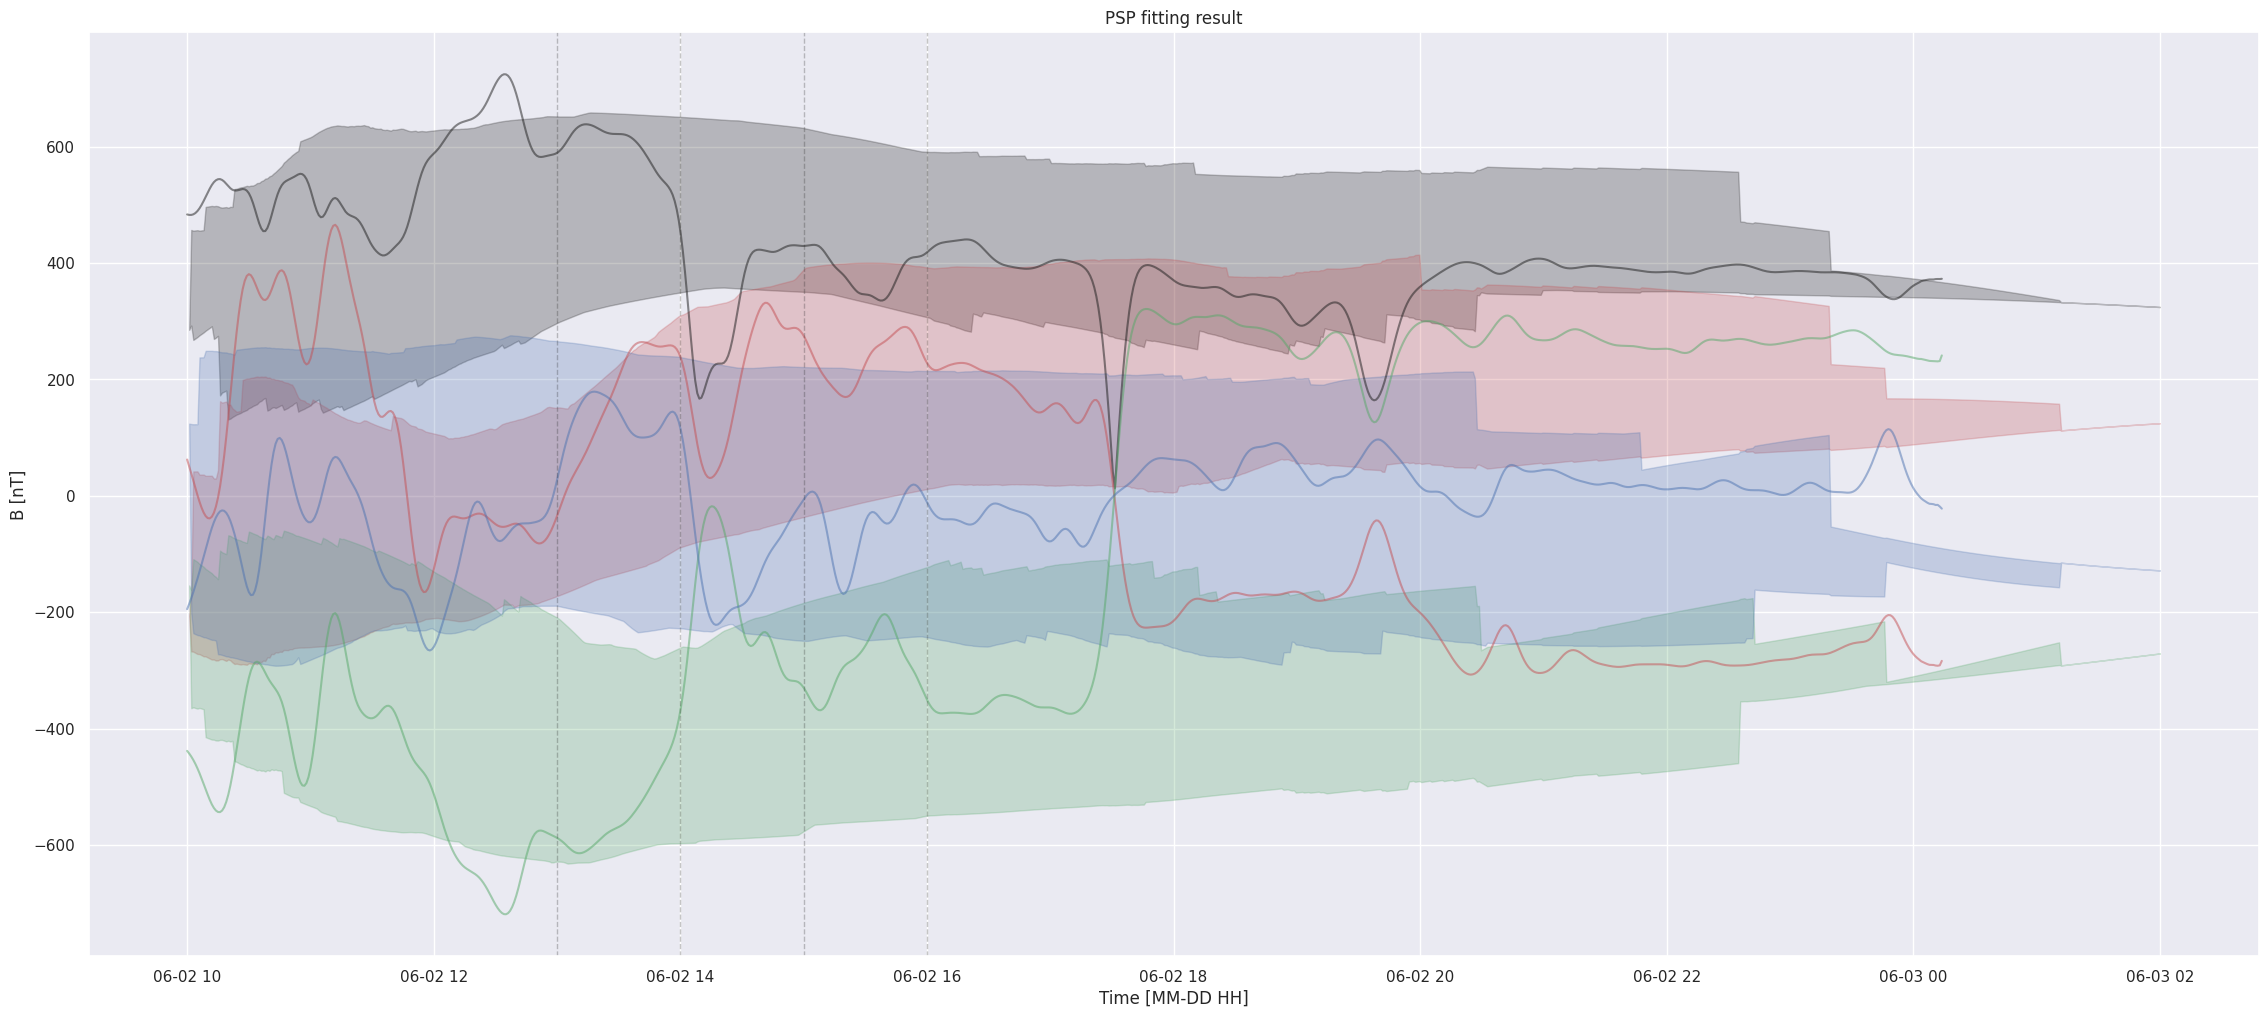

In [14]:
# plot the results 

t_s_psp = datetime.datetime(2022, 6, 2, 10, tzinfo=datetime.timezone.utc)
t_e_psp = datetime.datetime(2022, 6, 3, 2, tzinfo=datetime.timezone.utc)

# get measurements from PSP via heliosat
psp_t, psp_b = heliosat.PSP().get([t_s_psp, t_e_psp], "mag", reference_frame="HEEQ", as_endpoints=True, return_datetimes=True, smoothing="gaussian")

# get ensemble_data
ed = py3dcore_h4c.generate_ensemble(resfile[-1], psp_t, reference_frame="HEEQ", reference_frame_to="HEEQ", max_index=128)

plt.figure(figsize=(28, 12))
plt.title("PSP fitting result")
plt.plot(psp_t, np.sqrt(np.sum(psp_b**2, axis=1)), "k", alpha=0.5)
plt.plot(psp_t, psp_b[:, 0], "r", alpha=0.5)
plt.plot(psp_t, psp_b[:, 1], "g", alpha=0.5)
plt.plot(psp_t, psp_b[:, 2], "b", alpha=0.5)
plt.fill_between(psp_t, ed[0][3][0], ed[0][3][1], alpha=0.25, color="k")
plt.fill_between(psp_t, ed[0][2][0][:, 0], ed[0][2][1][:, 0], alpha=0.25, color="r")
plt.fill_between(psp_t, ed[0][2][0][:, 1], ed[0][2][1][:, 1], alpha=0.25, color="g")
plt.fill_between(psp_t, ed[0][2][0][:, 2], ed[0][2][1][:, 2], alpha=0.25, color="b")
plt.ylabel("B [nT]")
plt.xlabel("Time [MM-DD HH]")
for _ in t_psp:
    plt.axvline(x=_, lw=1, alpha=0.25, color="k", ls="--")
plt.show()

In [6]:
# read from pickle file
file = open(resfile[-1], "rb")
data = pickle.load(file)
file.close()

# get overview of whats in pickle file
cnt = 0
for item in data:
    print(item)
    cnt += 1
    
# get index ip for run with minimum eps    
epses_t = data["epses"]
ip = np.argmin(epses_t)    

# get parameters (stored in iparams_arr) for the run with minimum eps
model_objt = data["model_obj"]
iparams_arrt = model_objt.iparams_arr
iparams_arrt[ip]

locked
dt_0
model_kwargs
observers
model
iter_i
hist_eps
hist_time
hist_eps_dim
model_obj
data_obj
epses


array([ 0.00000000e+00, -1.10611565e+02, -2.70015106e+01,  9.46982193e+00,
        3.40600491e-01,  1.48324895e+00,  1.47068367e+01,  5.62534790e+02,
       -3.44976158e+01,  1.13999999e+00,  1.63999999e+00,  5.13122702e+00,
        1.16936767e+00,  2.87934204e+02], dtype=float32)

## Use scatter plot to plot range of all runs

In [7]:
df = pds.DataFrame(iparams_arrt)
cols = df.columns.values.tolist()

# drop first column, and others in which you are not interested
df.drop(df.columns[[0, 6, 9, 10]], axis=1, inplace=True)

# rename columns
df.columns = ['lon', 'lat', 'inc', 'D1AU', 'delta', 'init speed', 't factor', 'B1AU', 'gamma', 'vsw']
print(df.head())

          lon        lat       inc      D1AU     delta  init speed  \
0 -116.201508 -25.088425  2.536246  0.205696  3.965154  596.098328   
1 -114.387077 -27.134518  8.144411  0.319712  1.467727  669.583008   
2 -114.012192 -35.062927  4.720447  0.319684  3.383024  640.570618   
3 -117.603203 -28.115572  5.174006  0.224932  3.182705  704.429504   
4 -115.735222 -20.649677  2.794645  0.226783  2.569446  624.881592   

     t factor      B1AU     gamma         vsw  
0  -53.958710  5.136314  0.919198  416.673431  
1  -99.042572  5.696597  0.387844  342.254425  
2  -45.409855  6.057998  1.553110  381.223145  
3 -168.637772  5.078233  0.340517  349.007812  
4  -80.727531  6.772983  1.331636  323.756714  


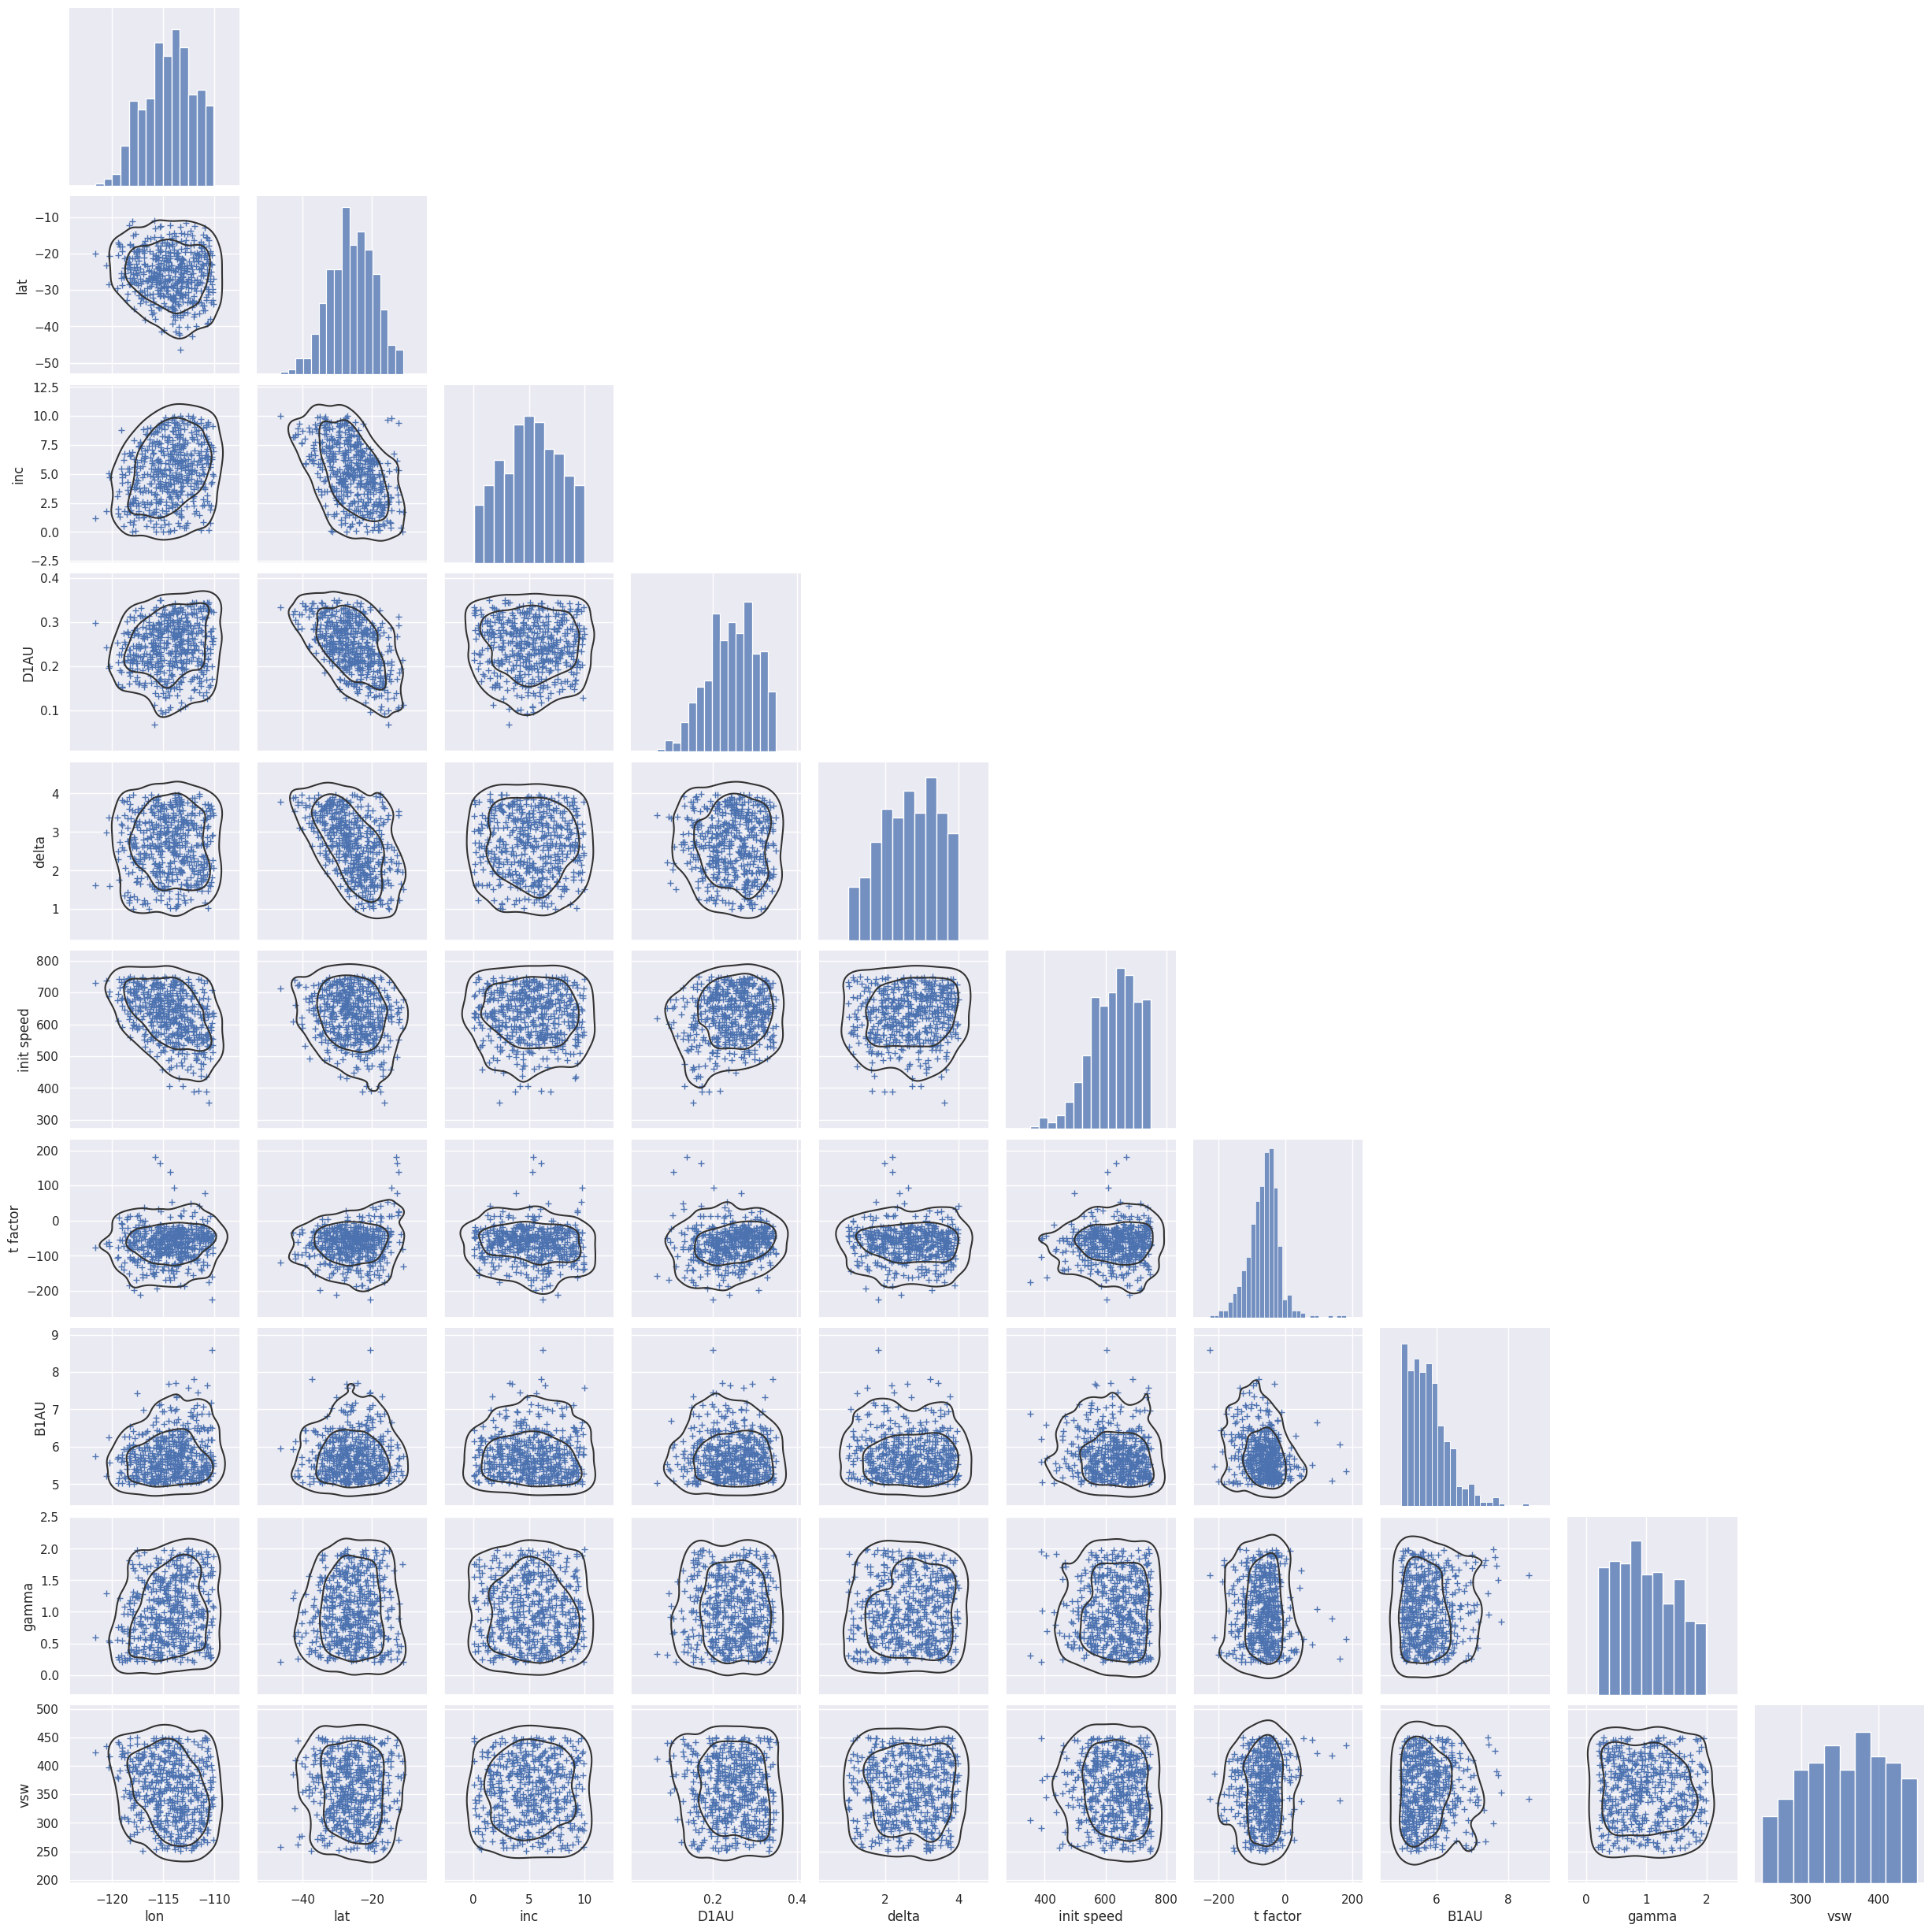

In [8]:
sns.set_style('white')
sns.set()

g = sns.pairplot(df, 
                 corner=True,
                 plot_kws=dict(marker="+", linewidth=1)
                )
g.map_lower(sns.kdeplot, levels=[0.05, 0.32], color=".2") #  levels are 2-sigma and 1-sigma contours
g.savefig(path+'scatter_plot_matrix.png')
plt.show()